In [1]:
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
%matplotlib widget
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from keras import layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers.legacy import Adagrad, SGD, Adam
from keras.metrics import Precision, Recall
import cv2
from PIL import ImageFont
from tqdm import tqdm


In [2]:
def open_data(path):

    # Path to the folder where HDF5 files are saved
    input_folder = path#

    # Initialize an empty list to store image data
    image_data_list = []
    cloud_map_data_list = []

    # Set norm temperature to normalize image data
    norm_temp = 50

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".h5"):
            input_path = os.path.join(input_folder, filename)

            with h5py.File(input_path, 'r') as file:
                # Check if 'image' dataset exists in the file
                if 'image' in file:
                    img_data = file['image'][:]
                    cp_data = file['label_map'][:]

                    #img_max_val = np.max((np.abs(img_data)))
                    
                    img_data = img_data/norm_temp

                    image_data_list.append(img_data)
                    cloud_map_data_list.append(cp_data)
                else:
                    print(f"Dataset 'image' not found in file: {input_path}")

    # Convert the list of image data to a numpy array
    image_data = np.array(image_data_list)
    #image_data = np.expand_dims(image_data, axis=-1)

    # min_value = -30
    # max_value = min(np.max(image_data), 30)
    # image_data = 2 * (image_data - min_value) / (max_value - min_value) - 1

    cloud_map_data = np.array(cloud_map_data_list)
    cloud_map_data = np.squeeze(cloud_map_data, axis=-2)

    # Display the shape of the resulting array
    print(f"Shape of the image data array: {image_data.shape}")
    print(f"Shape of the cloud map data array: {cloud_map_data.shape}")

    return image_data, cloud_map_data

def cut_images(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)

def cut_label(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)


In [3]:
image_data, cloud_map_data = open_data('/Users/lukas/Dokumente/Uni/SSI/CNN_data/cloudfirewater/high_res/')

Shape of the image data array: (38, 512, 640, 1)
Shape of the cloud map data array: (38, 512, 640, 4)


In [41]:
def define_class_weights(cloud_map_data): 
    class_counts = np.zeros(4)
    total_counts = (cloud_map_data.size/4)//1#.shape[0]*cloud_map_data.shape[1]*cloud_map_data.shape[2]

    # Sum the values in the last dimension to get the count for each class
    class_counts = np.sum(cloud_map_data, axis=(0, 1, 2))
    class_counts_inv = total_counts/np.sum(cloud_map_data, axis=(0, 1, 2))
    class_counts_inv = (class_counts_inv/np.min(class_counts_inv)).astype(int)

    class_weights = {
        0: 1,  # no_cloud
        1: 1,  # cloud
        2: 1,  # water
        3: 10  # fire
    }

    # Display the count for each class
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {round(count/total_counts,3)}")

    print(f"Total: {int(total_counts)} pixels")

    return class_weights

In [42]:
class_weights = define_class_weights(cloud_map_data)

Class 0: 0.725
Class 1: 0.179
Class 2: 0.096
Class 3: 0.0
Total: 12451840 pixels


In [536]:
### delete fire pixels in the label data ###
# cloud_water_map_data = np.delete(cloud_map_data, 3, axis=-1)
# cloud_water_map_data.shape

(38, 320, 256, 3)

In [9]:
section_size = 256
cut_frames = cut_images(image_data, section_size=section_size, overlap=0.25)
cut_labels = cut_label(cloud_map_data, section_size=section_size, overlap=0.25)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (228, 256, 256, 1)
Shape of the new data array: (228, 256, 256, 4)


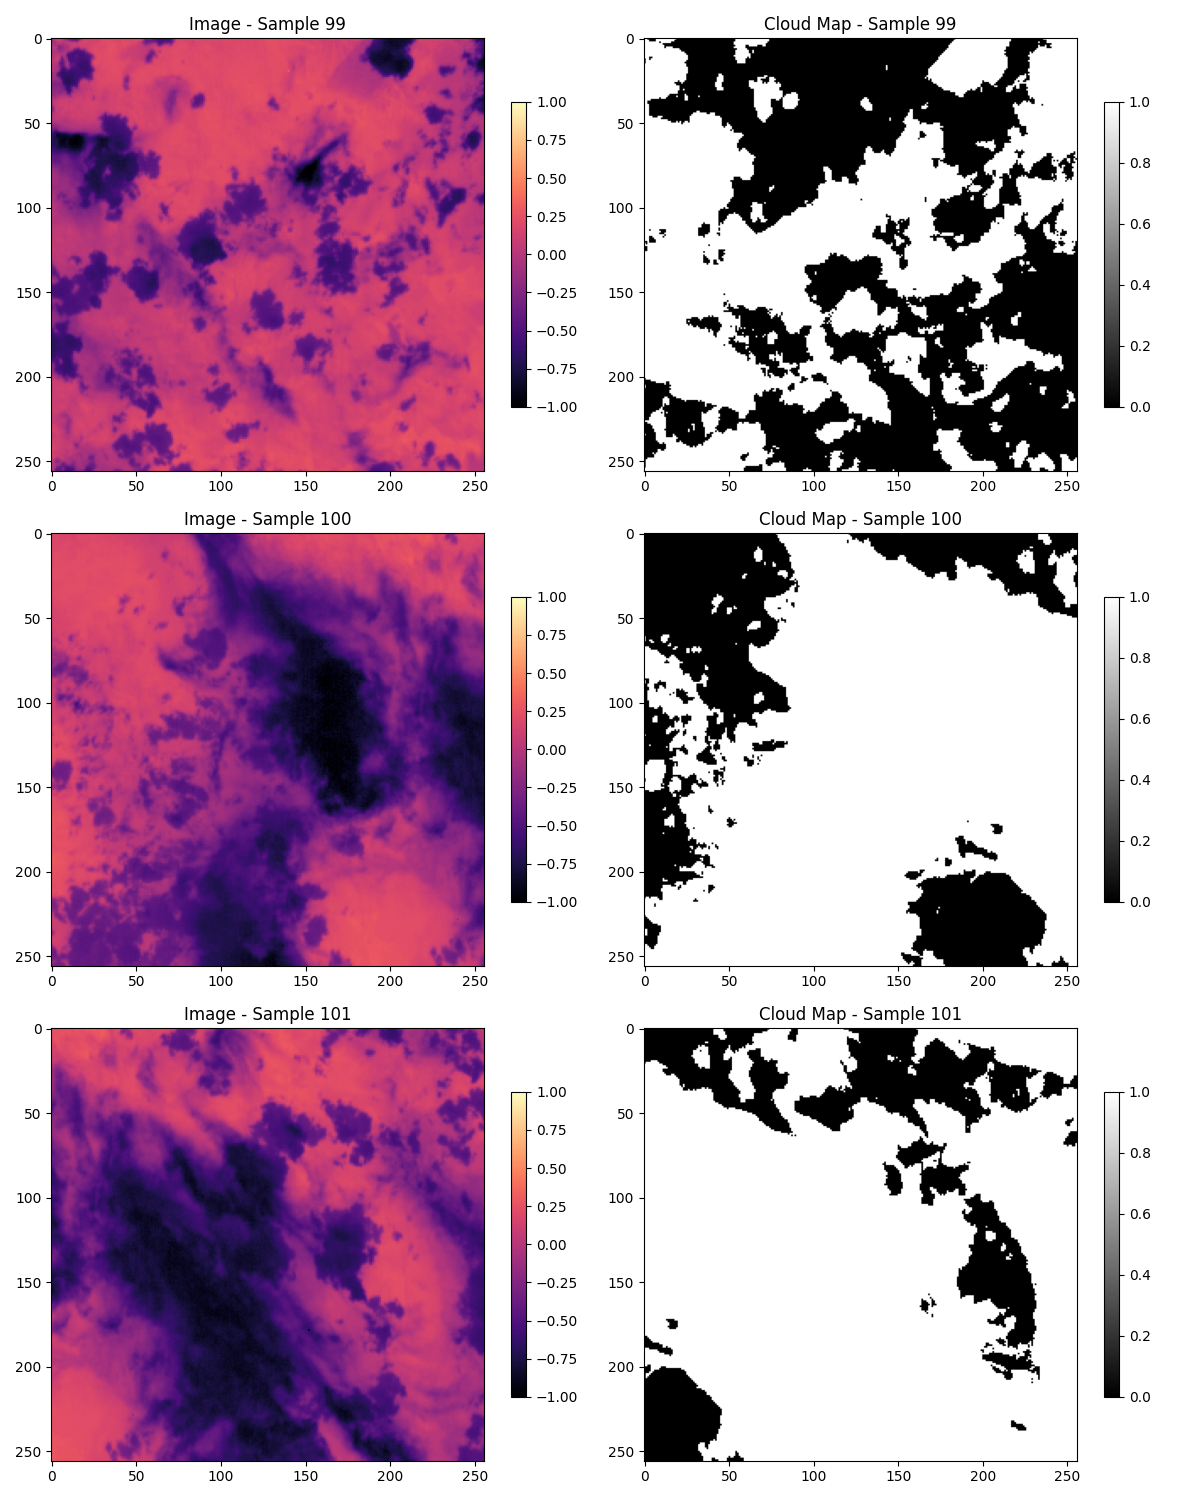

In [10]:
num_samples = 3
i_offset = 98

plt.close('all')
plt.figure(figsize=(12, 15))

# Plot the images and their corresponding cloud maps
for i in range(num_samples):
    # Plot the first image
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(cut_frames[i + i_offset, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title(f'Image - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    combined_map = np.argmax(cut_labels[i + i_offset, :, :, :], axis=-1)

    # Plot the corresponding cloud map
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(combined_map, cmap='binary_r')
    plt.title(f'Cloud Map - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

plt.tight_layout()
plt.show()

In [11]:
image_train, image_test, cloud_train, cloud_test = train_test_split(cut_frames, cut_labels, test_size=0.2, random_state=42)

In [12]:
def define_unet(input_shape):

    # Encoder
    inputs = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(32, (7, 7), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    #batch1 = layers.BatchNormalization()(conv1)
    conv2 = layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same')(conv1)
    batch2 = layers.BatchNormalization()(conv2)
    pool1 = layers.MaxPooling2D((2, 2))(batch2)

    conv3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
    batch3 = layers.BatchNormalization()(conv3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
    batch4 = layers.BatchNormalization()(conv4)
    pool2 = layers.MaxPooling2D((2, 2))(batch4)

    conv5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
    batch5 = layers.BatchNormalization()(conv5)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

    # Decoder
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.Concatenate()([up7, conv4])
    batch7 = layers.BatchNormalization()(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
    batch8 = layers.BatchNormalization()(conv7)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
    dropout8 = layers.Dropout(0)(conv8)

    up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
    concat9 = layers.Concatenate()([up9, conv2])
    batch9 = layers.BatchNormalization()(concat9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
    batch10 = layers.BatchNormalization()(conv9)
    conv10 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
    dropout10 = layers.Dropout(0)(conv10)

    # Output layer
    output = layers.Conv2D(4, (1, 1), activation='softmax')(dropout10)

    # Create the model
    model = models.Model(inputs=inputs, outputs=output)

    # Compile the model
    optimizer = SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

In [10]:
def define_unet(input_shape):

    # Encoder
    inputs = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    conv2 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(conv1)
    batch2 = layers.BatchNormalization()(conv2)
    pool1 = layers.MaxPooling2D((2, 2))(batch2)

    conv3 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
    batch3 = layers.BatchNormalization()(conv3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
    batch4 = layers.BatchNormalization()(conv4)
    pool2 = layers.MaxPooling2D((2, 2))(batch4)

    conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
    batch5 = layers.BatchNormalization()(conv5)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)
    batch6 = layers.BatchNormalization()(conv6)
    pool3 = layers.MaxPooling2D((2, 2))(batch6)

    #Bottleneck
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool3)
    batch7 = layers.BatchNormalization()(conv7)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)

    # Decoder
    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    concat9 = layers.Concatenate()([up9, conv6])
    batch9 = layers.BatchNormalization()(concat9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
    batch10 = layers.BatchNormalization()(conv9)
    conv10 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
    dropout10 = layers.Dropout(0)(conv10)

    up11 = layers.UpSampling2D(size=(2, 2))(dropout10)
    concat11 = layers.Concatenate()([up11, conv4])
    batch11 = layers.BatchNormalization()(concat11)
    conv11 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch11)
    batch12 = layers.BatchNormalization()(conv11)
    conv12 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch12)
    dropout12 = layers.Dropout(0.05)(conv12)

    up13 = layers.UpSampling2D(size=(2, 2))(dropout12)
    concat13 = layers.Concatenate()([up13, conv2])
    batch13 = layers.BatchNormalization()(concat13)
    conv13 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch13)
    batch14 = layers.BatchNormalization()(conv13)
    conv14 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch14)
    dropout14 = layers.Dropout(0.1)(conv14)

    # Output layer
    output = layers.Conv2D(4, (1, 1), activation='softmax')(dropout14)

    # Create the model
    model = models.Model(inputs=inputs, outputs=output)

    # Compile the model
    optimizer = SGD(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


In [13]:
model = define_unet(input_shape=input_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         1600      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         25632     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [14]:
datagen = ImageDataGenerator(
    rotation_range=45,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,   
    vertical_flip=True,   
    #channel_shift_range=0.025,
    fill_mode='reflect'
)

labelgen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

batch_size = 8
steps_per_epoch = len(image_train) // batch_size

# Fit the data generator to the training data (assuming you have a variable named 'train_images')
#datagen.fit(image_train)
gen_seed = 42

# Create a generator for both the input images and the ground truth masks
image_generator = datagen.flow(image_train, batch_size=batch_size, seed=gen_seed)
mask_generator = labelgen.flow(cloud_train, batch_size=batch_size, seed=gen_seed)

# Combine the generators into one using zip
train_generator = zip(image_generator, mask_generator)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=1e-4)


# Define a ModelCheckpoint callback to save the model at each epoch
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_best_only=False)


In [15]:
def plot_history(history):
    
    plt.close('all')
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.yticks(np.arange(0.8,1.01,0.01))
    #plt.ylim(0.89,1)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(top=1)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0)
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [61]:
history = model.fit(image_train, cloud_train,
                    batch_size=batch_size, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=100, 
                    validation_data=(image_test, cloud_test)
                    )

Epoch 1/100
44/44 [==============================] - 35s 792ms/step - loss: 1.0111 - accuracy: 0.6465 - val_loss: 0.9568 - val_accuracy: 0.6826
Epoch 2/100
44/44 [==============================] - 35s 799ms/step - loss: 0.6435 - accuracy: 0.7686 - val_loss: 0.8820 - val_accuracy: 0.6810
Epoch 3/100
44/44 [==============================] - 34s 775ms/step - loss: 0.5809 - accuracy: 0.7912 - val_loss: 0.8025 - val_accuracy: 0.6843
Epoch 4/100
24/44 [===============>..............] - ETA: 15s - loss: 0.5219 - accuracy: 0.7986

KeyboardInterrupt: 

In [16]:
history = model.fit(train_generator, 
                        batch_size=batch_size, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=100, 
                        class_weight=class_weights, 
                        validation_data=(image_test, cloud_test)
                        )

Epoch 1/100
22/22 [==============================] - 44s 2s/step - loss: 1.2649 - accuracy: 0.6092 - val_loss: 1.0414 - val_accuracy: 0.8594
Epoch 2/100
22/22 [==============================] - 42s 2s/step - loss: 1.0810 - accuracy: 0.7034 - val_loss: 0.9233 - val_accuracy: 0.7572
Epoch 3/100
22/22 [==============================] - 42s 2s/step - loss: 0.7671 - accuracy: 0.8032 - val_loss: 0.6415 - val_accuracy: 0.8814
Epoch 4/100
22/22 [==============================] - 43s 2s/step - loss: 0.7736 - accuracy: 0.8049 - val_loss: 0.7354 - val_accuracy: 0.6504
Epoch 5/100
22/22 [==============================] - 42s 2s/step - loss: 0.7397 - accuracy: 0.7920 - val_loss: 0.6819 - val_accuracy: 0.5997
Epoch 6/100
22/22 [==============================] - 43s 2s/step - loss: 0.8048 - accuracy: 0.7815 - val_loss: 0.7057 - val_accuracy: 0.6194
Epoch 7/100
22/22 [==============================] - 42s 2s/step - loss: 0.7690 - accuracy: 0.7794 - val_loss: 0.5467 - val_accuracy: 0.7187
Epoch 8/100
2

In [43]:
history_train = model.fit(train_generator, 
                            batch_size=batch_size, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=50, 
                            class_weight=class_weights, 
                            validation_data=(image_test, cloud_test)
                            #, callbacks=[reduce_lr]
                            )

# Append the values from history to history_main
history.history['loss'].extend(history_train.history['loss'])
history.history['val_loss'].extend(history_train.history['val_loss'])
history.history['accuracy'].extend(history_train.history['accuracy'])
history.history['val_accuracy'].extend(history_train.history['val_accuracy'])

Epoch 1/50
22/22 [==============================] - 43s 2s/step - loss: 0.1652 - accuracy: 0.9380 - val_loss: 0.1337 - val_accuracy: 0.9490
Epoch 2/50
22/22 [==============================] - 43s 2s/step - loss: 0.1740 - accuracy: 0.9342 - val_loss: 0.1274 - val_accuracy: 0.9521
Epoch 3/50
22/22 [==============================] - 42s 2s/step - loss: 0.1599 - accuracy: 0.9393 - val_loss: 0.1394 - val_accuracy: 0.9481
Epoch 4/50
22/22 [==============================] - 43s 2s/step - loss: 0.1644 - accuracy: 0.9387 - val_loss: 0.1306 - val_accuracy: 0.9506
Epoch 5/50
22/22 [==============================] - 42s 2s/step - loss: 0.1591 - accuracy: 0.9399 - val_loss: 0.1227 - val_accuracy: 0.9533
Epoch 6/50
22/22 [==============================] - 43s 2s/step - loss: 0.1518 - accuracy: 0.9431 - val_loss: 0.1308 - val_accuracy: 0.9503
Epoch 7/50
22/22 [==============================] - 42s 2s/step - loss: 0.1924 - accuracy: 0.9297 - val_loss: 0.1446 - val_accuracy: 0.9465
Epoch 8/50
22/22 [==

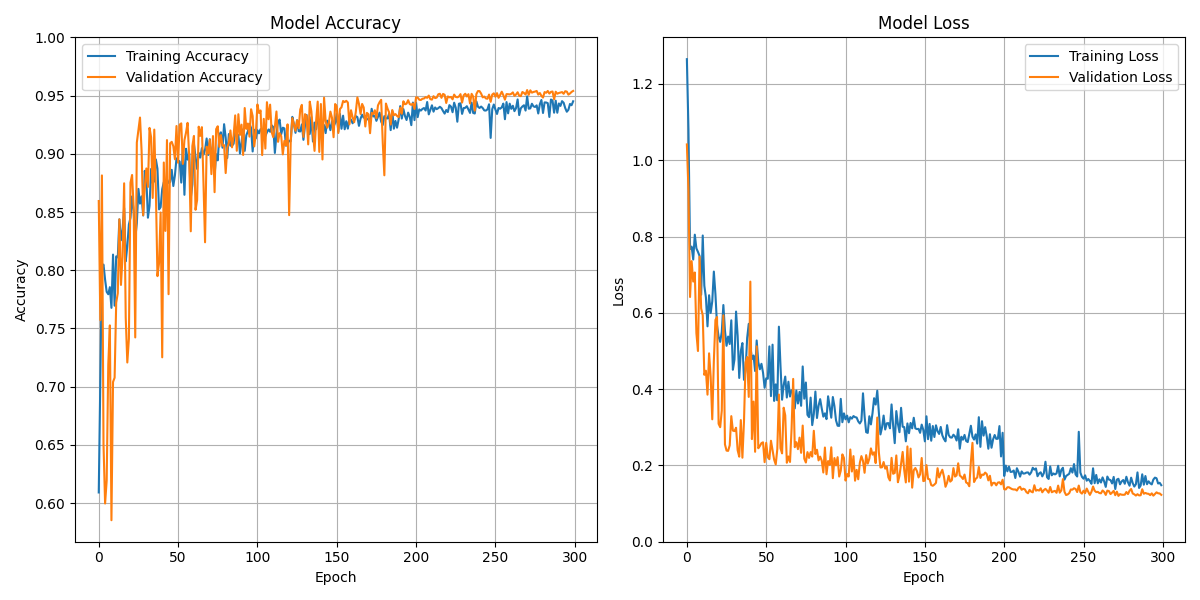

In [44]:
plot_history(history)

In [45]:
label = np.argmax(cloud_train, axis=-1)
data = image_train

#label = np.argmax(cloud_test, axis=-1)
#data = image_test


# Predict on test data
predictions = model.predict(data)

diff = np.zeros(predictions.shape)
diff = np.argmax(predictions, axis=-1) - label


6/6 [==============================] - 12s 2s/step


10 182


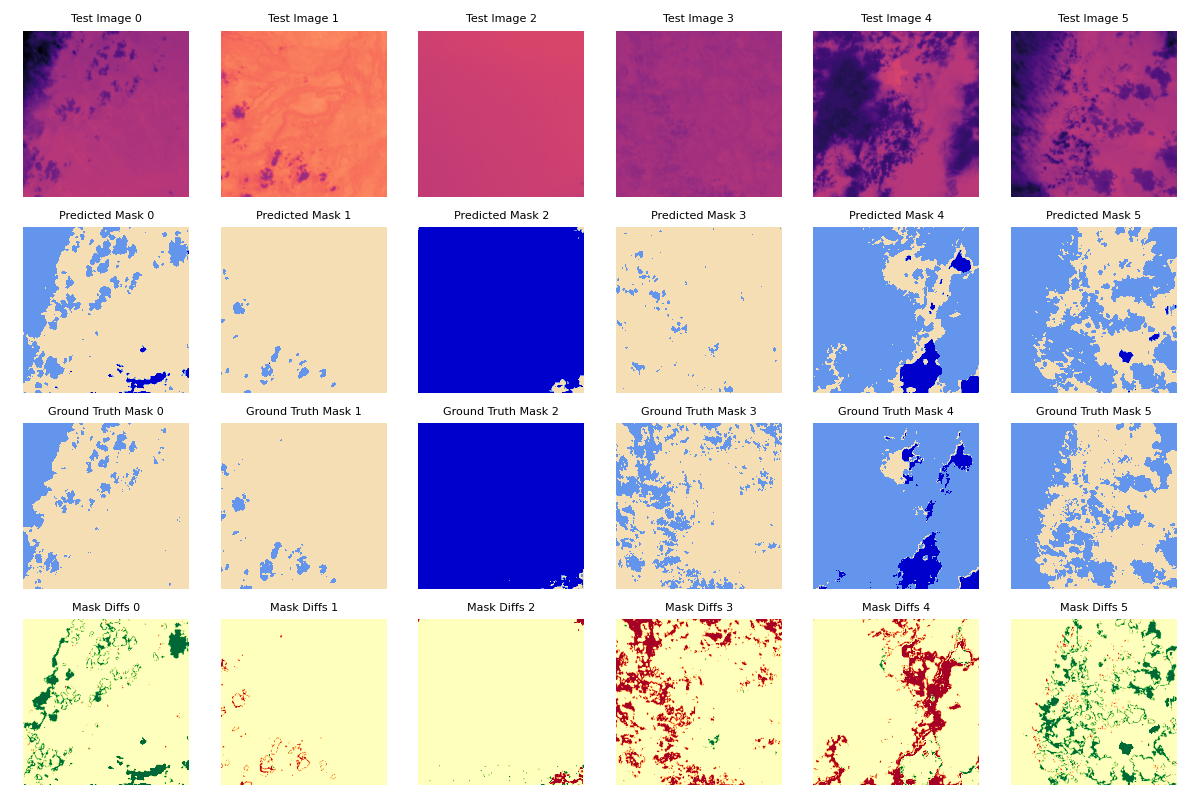

In [61]:
cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])

num_samples = 6

rand_offset = random.randint(0, data.shape[0]-num_samples-1)
#rand_offset = 0
print(rand_offset, data.shape[0])

# Plot a few samples  # You can change this number based on your preference
plt.close('all')
plt.figure(figsize=(12, 8))

for i in range(num_samples):
    # Original image (input)
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(data[i + rand_offset, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(i), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(np.argmax(predictions[i + rand_offset, :, :, :], axis=-1), cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Predicted Mask ' + str(i), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(label[i + rand_offset, :, :], cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Ground Truth Mask ' + str(i), fontsize=8)
    plt.axis('off')



    # diff[i + rand_offset, :, :, 0] = predictions[i + rand_offset, :, :, 0]-label[i + rand_offset, :, :, 0]

    # Diff mask
    plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    plt.imshow(diff[i + rand_offset, :, :], cmap='RdYlGn', vmin=-1., vmax=1.) #RdBu''
    plt.title('Mask Diffs ' + str(i), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [62]:
model.save('best_IR_clf_256x16_wc_temp.keras')

In [63]:
model = models.load_model('models/best_IR_clf_256x16_wc_2.keras')

In [103]:
def predict_classmap(img):
    #input_folder = path
    model = models.load_model('models/best_IR_clf_256x16_wc_2.keras')
    section_size = 256

    #class_maps = []

    #for filename in os.listdir(input_folder):
    #if filename.endswith(".png"):
    #input_path = os.path.join(input_folder, filename)
    #img = img#cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)/40  # Load image in grayscale mode
            
    # Resize image if not already in the expected input size
    original_height, original_width = img.shape[0:2]
            
    # Initialize an empty array for the output map
    prob_map = np.zeros((original_height, original_width, 4))
    class_map = np.zeros((original_height, original_width, 4))
    counter_map = np.zeros((original_height, original_width))

    edge = 5
            
    # Process each section
    for y in tqdm(range(0, original_height, section_size//2)):
        for x in range(0, original_width, section_size//2):
            
            # Handle edge cases by selecting the last 256x256 section on the edges
            if y + section_size > original_height:
                        y = original_height - section_size
            if x + section_size > original_width:
                        x = original_width - section_size

            section = img[y:y+section_size, x:x+section_size]
            section = np.expand_dims(section, axis=-1)  # Add channel dimension
            section = np.expand_dims(section, axis=0)  # Add batch dimension
            
            # Predict class map for the section
            pred = model.predict(section, verbose=0)
            
            pred = np.squeeze(pred)

            # Update class_map with predictions, prioritizing edge labels

            if edge > 0:
                prob_map[y+edge:y+section_size-edge, x+edge:x+section_size-edge] += pred[edge:-edge, edge:-edge] #np.argmax(pred, axis=-1) #np.maximum(class_map[y:y+section_size, x:x+section_size], np.argmax(pred, axis=-1))
                counter_map[y+edge:y+section_size-edge, x+edge:x+section_size-edge] += 1 # counter_map[y:y+section_size, x:x+section_size] + 1
            elif edge == 0:
                prob_map[y:y+section_size, x:x+section_size] += pred #np.argmax(pred, axis=-1) #np.maximum(class_map[y:y+section_size, x:x+section_size], np.argmax(pred, axis=-1))
                counter_map[y:y+section_size, x:x+section_size] += 1 # counter_map[y:y+section_size, x:x+section_size] + 1
    
    class_map = np.argmax(prob_map, axis=-1)# np.round(class_map/counter_map)
    #class_maps.append(class_map)
    if edge > 0:
        prob_map = prob_map[edge:-edge, edge:-edge]
        counter_map = counter_map[edge:-edge, edge:-edge]

    prob_map = prob_map/counter_map[:,:,None]

    #parameterize fire hotspots 
    fire_map = (class_map == 3).astype(np.uint8)
    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(fire_map, connectivity=8)

    if num_labels > 1:
        hotspots = np.hstack((centroids[1:,:], stats[1:,4].reshape(-1,1)))
    elif num_labels == 1:
        hotspots = []
            
    return class_map, prob_map, hotspots



In [65]:
idx=0

In [115]:
idx += 1
if idx > image_data.shape[0]-1: idx = 0
print('Image ID: ' + str(idx))

class_map, prob_map, hotspots = predict_classmap(image_data[idx])

Image ID: 20


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


In [78]:
def plot_predictions(idx, image_data, prob_map, hotspots):
    cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])

    plt.close('all')
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.imshow(image_data[idx], cmap='magma', vmin=-1, vmax=1)
    plt.colorbar(shrink=0.65)
    plt.title('Input Image', pad=10)

    plt.subplot(2,4,3)
    plt.imshow(prob_map[:,:,0], cmap='Greens', vmin=0.9, vmax=1.05)
    plt.title('Output Landmass ($P_{max}$ = ' + str(round(np.max(prob_map[:,:,0])*100,2)) + '%)', fontsize=9)

    plt.subplot(2,4,4)
    plt.imshow(prob_map[:,:,1], cmap='Purples', vmin=0, vmax=1.1)
    plt.title('Output Cloud ($P_{max}$ = ' + str(round(np.max(prob_map[:,:,1])*100,2)) + '%)', fontsize=9)

    plt.subplot(2,4,7)
    plt.imshow(prob_map[:,:,2], cmap='Blues', vmin=0.3, vmax=1.2)
    plt.title('Output Water ($P_{max}$ = ' + str(round(np.max(prob_map[:,:,2])*100,2)) + '%)', fontsize=9)

    # Plot the circles on the "Output Fire" subplot
    ax = plt.subplot(2,4,8)
    plt.imshow(prob_map[:,:,3], cmap='Oranges', vmin=0, vmax=0.5)
    plt.title('Output Fire ($P_{max}$ = ' + str(round(np.max(prob_map[:,:,3])*100,2)) + '%)', fontsize=9)

    # Adding circles
    for x, y, area in hotspots:
        radius = 5 + 3*np.sqrt(area)  # Assuming the area is actually the square of the radius
        circle = Circle((x-5, y-5), radius, color='orangered', fill=False, linewidth=1, alpha=0.5)
        ax.add_patch(circle)
    #plt.legend()

    plt.show()

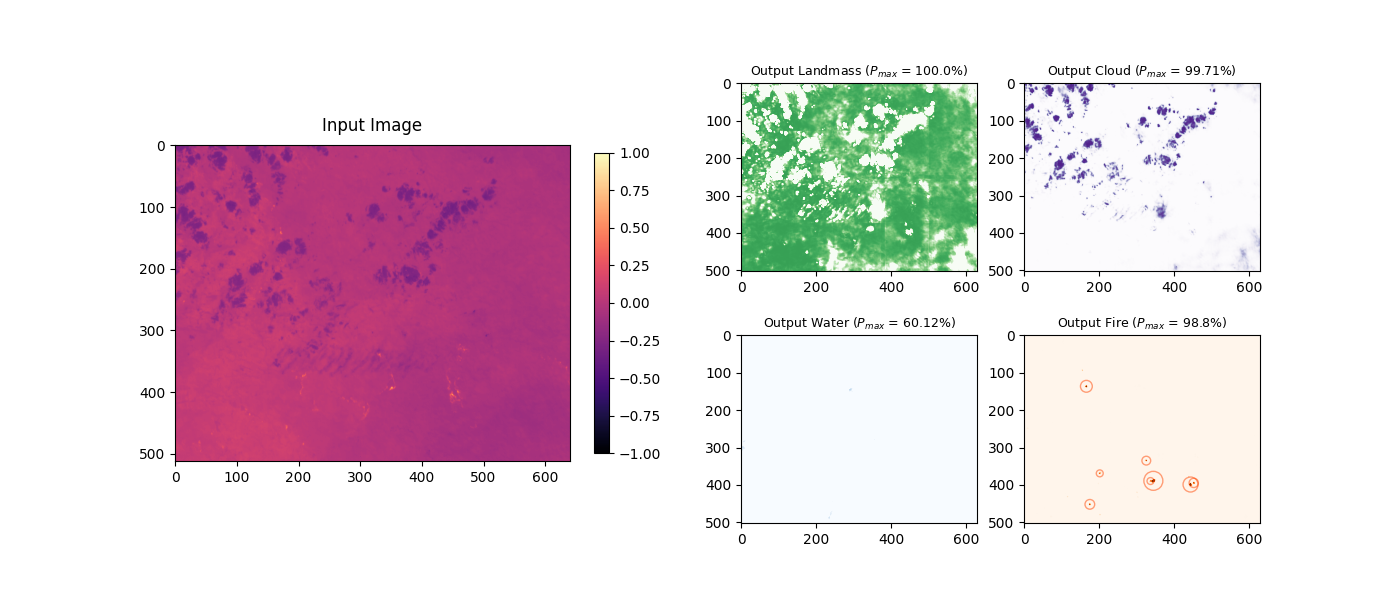

In [116]:
plot_predictions(idx, image_data, prob_map, hotspots)